## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [1]:
from covid_data import CovidData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
#!{sys.executable} -m pip install ipyleaflet
#!{sys.executable} -m pip install ipywidgets

In [2]:
#!jupyter nbextension enable --py --sys-prefix ipyleaflet
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline, WidgetControl
)

from ipywidgets import HTML

In [4]:
covid_data_manager = CovidData()

bin_region_column = 'state'
covid_data, routes_data = covid_data_manager.getData(bin_region_column=bin_region_column)
data_confirmed = covid_data['confirmed']
data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20
0,Alabama,US,32.884280,-86.710122,0,0,0,0,0,0,...,10464,10700,11101,11373,11674,11771,12086,12376,13052,13288
1,Alaska,US,60.261375,-145.838598,0,0,0,0,0,0,...,379,379,379,387,387,387,387,399,401,401
2,Alberta,Canada,53.933300,-116.576500,0,0,0,0,0,0,...,6345,6407,6457,6515,6587,6644,6683,6716,6735,6768
3,American Samoa,US,-14.271000,-170.132000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,none,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,375,375,375,375,376,381,388,391,398,423
317,none,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
318,none,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,65,70,85,106,122,128,130,167,184,197
319,none,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,441,446,654,654,679,753,761,772,832,866


In [5]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]

def clean_routes(routes, bin_region_column):
    if bin_region_column == 'county':
        return routes.loc[~((routes['DepartCounty'] == routes['ArrivalCounty']) &
                            (routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    elif bin_region_column == 'state':
        return routes.loc[~((routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    else:
        return routes.loc[~(routes['DepartCountry/Region'] == routes['ArrivalCountry/Region'])]
    
data_confirmed = clean_data(data_confirmed)
routes = clean_routes(routes_data, bin_region_column)

In [161]:
import networkx as nx

def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def route_indexes_between_nodes(node_loc_0, node_loc_1, routes, bin_region_column):
        node_loc_names_0 = node_loc_0.split(':')
        node_loc_names_1 = node_loc_1.split(':')
        
        if bin_region_column == 'county':
            from_0_to_1 = ((routes['DepartCounty'] == node_loc_names_0[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_0[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_1[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[2]))
            
            from_1_to_0 = ((routes['DepartCounty'] == node_loc_names_1[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_1[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_0[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[2]))
        elif bin_region_column == 'state':
            from_0_to_1 = ((routes['DepartProvince/State'] == node_loc_names_0[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[1]))
            
            from_1_to_0 = ((routes['DepartProvince/State'] == node_loc_names_1[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[1]))
        else:
            from_0_to_1 = ((routes['DepartCountry/Region'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[0]))
            
            from_1_to_0 = ((routes['DepartCountry/Region'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[0]))
        return from_0_to_1, from_1_to_0
    
def get_cases_on_date(name_loc, data_confirmed, date, bin_region_column):
    name_loc_split = name_loc.split(':')
    if bin_region_column == 'county':
        return data_confirmed.loc[(data_confirmed['County'] == name_loc_split[0]) &
                                  (data_confirmed['Province/State'] == name_loc_split[1]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[2])][date]
    elif bin_region_column == 'state':
        return data_confirmed.loc[(data_confirmed['Province/State'] == name_loc_split[0]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[1])][date]
    else:
        return data_confirmed.loc[(data_confirmed['Country/Region'] == name_loc_split[0])][date]
    
def get_dates(data_confirmed, bin_region_column):
    if bin_region_column == 'county':
        return data_confirmed.columns.tolist()[5:]
    if bin_region_column == 'state':
        return data_confirmed.columns.tolist()[4:]
    if bin_region_column == 'country':
        return data_confirmed.columns.tolist()[3:]

def get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column):
    def get_loc_name(df_row, bin_region_column=bin_region_column):
        if bin_region_column == 'county':
            return "{}:{}:{}".format(df_row['County'], df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'state':
            return "{}:{}".format(df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'country':
            return "{}".format(df_row['Country/Region'])
        return None
    
    def get_initial_case(data_confirmed, dates):
        first_date = dates[0]
        return data_confirmed.sort_values(first_date).iloc[-1]
    
    infect_graph = nx.Graph()
    dates = get_dates(data_confirmed, bin_region_column)
    case_zero = get_initial_case(data_confirmed, dates)
    case_zero_name = get_loc_name(case_zero)
    infect_graph.add_node(case_zero_name)
    location_pos = {case_zero_name : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}
    infected_parents = {case_zero_name : []}
    new_locs = {dates[0] : [case_zero_name]}
    new_edges = {}

    for date in dates:
        if not date == dates[0]:
            new_locs[date] = []
        
        new_edges[date] = []
        
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        
        for _index, row in conf_sort_day.iterrows():
            node_loc = get_loc_name(row)
            
            if not infect_graph.has_node(node_loc):
                already_infected = infect_graph.nodes
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(node_loc, pos=coords)
                infected_parents[node_loc] = []
                location_pos[node_loc] = coords
                new_locs[date] = new_locs[date] + [node_loc]
                # connect_to_infect = False - eventually for getting a connected graph
                
                for infected in already_infected:
                    from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, node_loc, routes, bin_region_column)
                    
                    if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                        infect_graph.add_edge(infected, node_loc)
                        new_edges[date] = new_edges[date] + [(infected, node_loc)]
                        
                    if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                        infected_parents[infected] = infected_parents[infected] + [node_loc]
                
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges

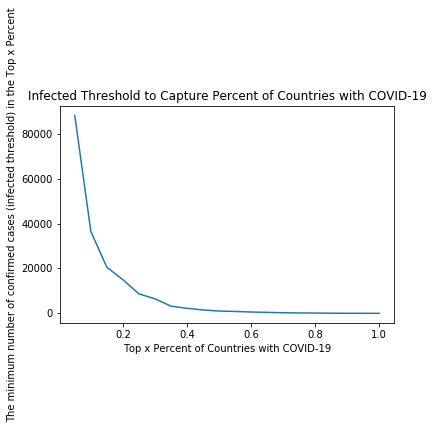

In [162]:
plt.plot([xx for xx in np.arange(0.05, 1.05, 0.05)], 
         [ get_initial_infect_thresh(data_confirmed, xx) for xx in np.arange(0.05, 1.05, 0.05)])
plt.title("Infected Threshold to Capture Percent of Countries with COVID-19")
plt.xlabel("Top x Percent of Countries with COVID-19")
plt.ylabel("The minimum number of confirmed cases (infected threshold) in the Top x Percent")
plt.show()

In [163]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 1.00)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges = get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column)

INITIAL INFECTION THRESHOLD SET TO 1


{'1/22/20': [('Hubei:China', 'none:Taiwan*'),
  ('Anhui:China', 'none:Taiwan*'),
  ('Hubei:China', 'none:Korea, South'),
  ('Anhui:China', 'none:Korea, South'),
  ('none:Taiwan*', 'Ningxia:China'),
  ('none:Korea, South', 'Ningxia:China'),
  ('none:Taiwan*', 'Hebei:China'),
  ('none:Korea, South', 'Hebei:China'),
  ('none:Taiwan*', 'Jiangsu:China'),
  ('none:Korea, South', 'Jiangsu:China'),
  ('none:Taiwan*', 'Fujian:China'),
  ('none:Korea, South', 'Fujian:China'),
  ('none:Taiwan*', 'Shanxi:China'),
  ('none:Korea, South', 'Shanxi:China'),
  ('none:Taiwan*', 'Guizhou:China'),
  ('none:Korea, South', 'Guizhou:China'),
  ('none:Taiwan*', 'Macau:China'),
  ('none:Korea, South', 'Macau:China'),
  ('none:Taiwan*', 'Washington:US'),
  ('none:Korea, South', 'Washington:US'),
  ('none:Taiwan*', 'Yunnan:China'),
  ('none:Korea, South', 'Yunnan:China'),
  ('none:Taiwan*', 'Shandong:China'),
  ('none:Korea, South', 'Shandong:China'),
  ('none:Taiwan*', 'Jiangxi:China'),
  ('Hubei:China', 'none:

In [164]:
def generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, date, bin_region_column, scale=3):
    infect_graph = infect_graphs[date]
    max_confirm = max_confirmed[date]
    
    marker_layer = LayerGroup(name='markers')
    circle_layer = LayerGroup(name='circles')
    
    for name_loc in infect_graph.nodes:
        marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, visibile=True, opacity=0)
        marker_layer.add_layer(marker)
        
        circle = Circle(location=location_pos[name_loc], 
                        radius=int(get_cases_on_date(name_loc, data_confirmed, date, bin_region_column)*scale),#/max_confirm*scale),
                        color = 'red', fill_color = 'red')
        circle_layer.add_layer(circle)
    
    return marker_layer, circle_layer
    
def generate_routes(infect_graphs, location_pos, routes_df, date, bin_region_column):
    infect_graph = infect_graphs[date]
    max_route = max(routes['NumberOfRoutes'])
    line_layer = LayerGroup(name='Lines')
    for c1, c2 in infect_graph.edges:
        c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, routes, bin_region_column)
        try:
            c1_to_c2 = routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
        line = Polyline(locations=[location_pos[c1], location_pos[c2]], color='white', opacity=routes_between/max_route)
        line_layer.add_layer(line)
        
    return line_layer

In [82]:
DATE = '4/2/20'

infection_map = Map(basemap=basemaps.CartoDB.DarkMatter, center=(0,0), zoom=1)
infection_map.add_control(FullScreenControl())
marker_layer, circle_layer = generate_graph(infect_graphs, location_pos, max_confirmed, data_confirmed, DATE, bin_region_column)
line_layer = generate_routes(infect_graphs, location_pos, routes, DATE, bin_region_column)

infection_map.add_layer(marker_layer)
infection_map.add_layer(circle_layer)
infection_map.add_layer(line_layer)

In [83]:
infection_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [185]:
def create_time_map():
    time_infection_map = Map(basemap=basemaps.CartoDB.DarkMatter, center=(0,0), zoom=1.25)
    time_infection_map.add_control(FullScreenControl())

    date_msg = HTML(value = '',)

    #time_map = VBox([date_msg, time_infection_map])

    marker_layer, circle_layer, line_layer = None, None, None

    date_control = WidgetControl(widget=date_msg, position='topright')
    time_infection_map.add_control(date_control)
    
    return time_infection_map, date_msg, marker_layer, circle_layer, line_layer

In [182]:
time_infection_map, date_msg, marker_layer, circle_layer, line_layer = create_time_map()
time_infection_map

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [174]:
import time

def clear_layers(infection_map, marker_layer, circle_layer, line_layer):
    if marker_layer == None: return
    
    infection_map.remove_layer(marker_layer)
    infection_map.remove_layer(circle_layer)
    infection_map.remove_layer(line_layer)

def get_infected_at_location(lat, long, location_pos, data_confirmed, date, bin_region_column, scale):
    name_loc = None
    for test_name_loc in location_pos:
        test_lat, test_long = location_pos[test_name_loc]
        if test_lat == lat and test_long == long:
            name_loc = test_name_loc
            break
            
    assert not name_loc == None, "Ok... something has really messed up here..."
    
    return int(get_cases_on_date(name_loc, data_confirmed, date, bin_region_column)*scale)
    

def update_layers(marker_layer, circle_layer, line_layer, date_msg, infect_graphs, location_pos, data_confirmed, date, 
                  new_edges, new_locs, max_route, bin_region_column, scale=3):
    
    for name_loc in new_locs[date]:
        print("New Infected Location: {}".format(name_loc))
        marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, opacity=0)
        marker_layer.add_layer(marker)
        
        circle = Circle(location=location_pos[name_loc], 
                        radius=int(get_cases_on_date(name_loc, data_confirmed, date, bin_region_column)*scale),#/max_confirm*scale),
                        color = 'red', fill_color = 'red')
        circle_layer.add_layer(circle)
        
    for c1, c2 in new_edges[date]:
        c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, routes, bin_region_column)
        try:
            c1_to_c2 = routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
        line = Polyline(locations=[location_pos[c1], location_pos[c2]], color='white', opacity=0.02)#routes_between/max_route)
        line_layer.add_layer(line)
        
    for circle in circle_layer.layers:
        lat, long = circle.location
        circle.radius = get_infected_at_location(lat, long, location_pos, data_confirmed, date, bin_region_column,
                                                 scale)
        
    date_msg.value = '<p>Date: {}</p>'.format(date)
        
def display_infection_graph_time(infect_graphs, location_pos, max_confirmed, data_confirmed, 
                                 routes, infection_map, dates, new_edges, new_locs, bin_region_column, date_msg,
                                 period=0.5):
    
    marker_layer, circle_layer, line_layer = None, None, None
        
    print("Starting Animation in 5 seconds!")
    time.sleep(5.0)
    for date in dates:
        print(date)
        if date == dates[0]:
            marker_layer, circle_layer = generate_graph(infect_graphs, location_pos, max_confirmed, 
                                                        data_confirmed, date, bin_region_column,scale=3)
            line_layer = generate_routes(infect_graphs, location_pos, routes, date, bin_region_column)
            
            date_msg.value = '<p>Date: {}</p>'.format(date)
            
            infection_map.add_layer(marker_layer)
            infection_map.add_layer(circle_layer)
            infection_map.add_layer(line_layer)
            
        else:
            max_route = max(routes['NumberOfRoutes'])
            update_layers(marker_layer, circle_layer, line_layer, date_msg, infect_graphs, location_pos, 
                          data_confirmed, date, new_edges, new_locs, max_route, bin_region_column, scale=3)
            
        time.sleep(period)
    return marker_layer, circle_layer, line_layer

Starting Animation in 5 seconds!
1/22/20
1/23/20
New Infected Location: none:Singapore
New Infected Location: Jilin:China
New Infected Location: none:Vietnam
New Infected Location: Xinjiang:China
New Infected Location: Hong Kong:China
New Infected Location: Heilongjiang:China
New Infected Location: Gansu:China
New Infected Location: Shaanxi:China
1/24/20
New Infected Location: Inner Mongolia:China
New Infected Location: Illinois:US
New Infected Location: none:France
1/25/20
New Infected Location: Qinghai:China
New Infected Location: none:Nepal
New Infected Location: none:Malaysia
1/26/20
New Infected Location: Arizona:US
New Infected Location: Ontario:Canada
New Infected Location: Victoria:Australia
New Infected Location: California:US
New Infected Location: New South Wales:Australia
1/27/20
New Infected Location: none:Germany
New Infected Location: none:Sri Lanka
New Infected Location: none:Cambodia
1/28/20
New Infected Location: British Columbia:Canada
1/29/20
New Infected Location: 

3/15/20
New Infected Location: Prince Edward Island:Canada
New Infected Location: none:Equatorial Guinea
New Infected Location: none:Congo (Brazzaville)
New Infected Location: Newfoundland and Labrador:Canada
New Infected Location: none:Uzbekistan
New Infected Location: Mayotte:France
New Infected Location: none:Central African Republic
3/16/20
New Infected Location: none:Liberia
New Infected Location: none:Benin
New Infected Location: Virgin Islands:US
New Infected Location: none:Bahamas
New Infected Location: Greenland:Denmark
New Infected Location: none:Tanzania
New Infected Location: none:Somalia
New Infected Location: Guam:US
New Infected Location: Puerto Rico:US
New Infected Location: Nova Scotia:Canada
New Infected Location: District of Columbia:US
3/17/20
New Infected Location: none:Gambia
New Infected Location: none:Montenegro
New Infected Location: none:Barbados
3/18/20
New Infected Location: Montserrat:United Kingdom
New Infected Location: West Virginia:US
New Infected Locat

In [ ]:
clear_layers(time_infection_map, marker_layer, circle_layer, line_layer)
dates = get_dates(data_confirmed, bin_region_column)
marker_layer, circle_layer, line_layer = display_infection_graph_time(infect_graphs, location_pos, max_confirmed, 
                                                                      data_confirmed, routes, time_infection_map, 
                                                                      dates, new_edges, new_locs, bin_region_column,
                                                                      date_msg, period=0.1)

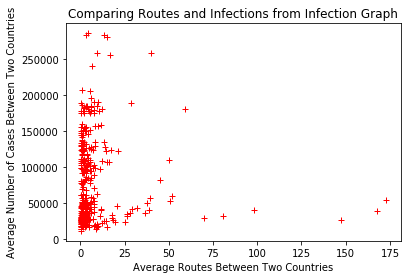

In [148]:
import matplotlib.pyplot as plt
def plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed):
    latest_date = data_confirmed.columns[-1]
    infect_graph = infect_graphs[latest_date]
    
    avg_routes_between = []
    avg_cases_between = []
    for c1, c2 in infect_graph.edges:
        c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, routes, bin_region_column)
        try:
            c1_to_c2 = routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c1_to_c2 = 0
        try:
            c2_to_c1 = routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
        except:
            c2_to_c1 = 0
        
        avg_r_between = (c1_to_c2 + c2_to_c1)/2
        c1_cases = get_cases_on_date(c1, data_confirmed, latest_date, bin_region_column).tolist()[0]
        c2_cases = get_cases_on_date(c2, data_confirmed, latest_date, bin_region_column).tolist()[0]
        avg_cases = (c1_cases + c2_cases)/2
#         if avg_cases > 1000000:
#             print("HIGHEST AVERAGE BETWEEN LOCATIONS {} AND {} IS {}".format(c1, c2, avg_cases))
#             #continue
#         if avg_cases > 500000:
#             print("HIGH AVERAGE BETWEEN LOCATIONS {} AND {} IS {}".format(c1, c2, avg_cases))
#             #continue
        
        avg_routes_between.append(avg_r_between)
        avg_cases_between.append(avg_cases)
        
    plt.plot(avg_routes_between, avg_cases_between, 'r+')
    plt.title("Comparing Routes and Infections from Infection Graph")
    plt.xlabel("Average Routes Between Two Countries")
    plt.ylabel("Average Number of Cases Between Two Countries")
        
plot_latest_routes_to_cases(infect_graphs, routes, data_confirmed)

In [176]:
infected_parents

{'Hubei:China': ['Anhui:China',
  'none:Taiwan*',
  'none:Korea, South',
  'Ningxia:China',
  'Hebei:China',
  'Jiangsu:China',
  'Fujian:China',
  'Shanxi:China',
  'Guizhou:China',
  'Macau:China',
  'Yunnan:China',
  'Shandong:China',
  'none:Japan',
  'Guangxi:China',
  'Liaoning:China',
  'none:Thailand',
  'Hainan:China',
  'Hunan:China',
  'Tianjin:China',
  'Sichuan:China',
  'Henan:China',
  'Chongqing:China',
  'Shanghai:China',
  'Zhejiang:China',
  'Beijing:China',
  'Guangdong:China',
  'none:Singapore',
  'Jilin:China',
  'none:Vietnam',
  'Xinjiang:China',
  'Hong Kong:China',
  'Shaanxi:China',
  'none:France',
  'none:Malaysia',
  'California:US',
  'none:Cambodia',
  'Queensland:Australia',
  'none:United Arab Emirates',
  'none:Italy',
  'none:Russia',
  'none:Indonesia',
  'Alaska:US'],
 'Anhui:China': ['none:Taiwan*',
  'none:Korea, South',
  'Ningxia:China',
  'Hebei:China',
  'Fujian:China',
  'Shanxi:China',
  'Guizhou:China',
  'Macau:China',
  'Yunnan:China',


In [178]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 0.20)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs_top_20, location_pos_top_20, max_confirmed_top_20, infected_parents_top_20, new_locs_top_20, new_edges_top_20 = get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column)

INITIAL INFECTION THRESHOLD SET TO 15003


In [188]:
time_infection_map_top_20, date_msg_top_20, marker_layer_top_20, circle_layer_top_20, line_layer_top_20 = create_time_map()
time_infection_map_top_20

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [192]:
clear_layers(time_infection_map_top_20, marker_layer_top_20, circle_layer_top_20, line_layer_top_20)
dates = get_dates(data_confirmed, bin_region_column)
marker_layer_top_20, circle_layer_top_20, line_layer_top_20 = display_infection_graph_time(infect_graphs_top_20, 
        location_pos_top_20, max_confirmed_top_20, data_confirmed, routes, time_infection_map_top_20, 
        dates, new_edges_top_20, new_locs_top_20, bin_region_column, date_msg_top_20, period=1.0)

Starting Animation in 5 seconds!
1/22/20
1/23/20
1/24/20
1/25/20
1/26/20
1/27/20
1/28/20
1/29/20
1/30/20
1/31/20
2/1/20
2/2/20
2/3/20
2/4/20
2/5/20
2/6/20
2/7/20
2/8/20
2/9/20
2/10/20
2/11/20
2/12/20
2/13/20
2/14/20
2/15/20
2/16/20
2/17/20
2/18/20
2/19/20
2/20/20
2/21/20
2/22/20
2/23/20
2/24/20
2/25/20
2/26/20
2/27/20
2/28/20
2/29/20
3/1/20
3/2/20
3/3/20
3/4/20
3/5/20
3/6/20
3/7/20
3/8/20
3/9/20
3/10/20
3/11/20
3/12/20
New Infected Location: none:Italy
3/13/20
3/14/20
3/15/20
3/16/20
3/17/20
New Infected Location: none:Iran
3/18/20
3/19/20
New Infected Location: none:Germany
New Infected Location: none:Spain
3/20/20
3/21/20
3/22/20
New Infected Location: New York:US
New Infected Location: none:France
3/23/20
3/24/20
3/25/20
3/26/20
3/27/20
3/28/20
New Infected Location: none:United Kingdom
3/29/20
3/30/20
New Infected Location: none:Switzerland
3/31/20
New Infected Location: New Jersey:US
4/1/20
New Infected Location: none:Turkey
4/2/20
New Infected Location: none:Belgium
4/3/20
New In